In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
import os
import pickle
from glob import iglob
import numpy as np
import librosa
import soundfile as sf

ORI_PATH = r'C:\Users\usaco\Desktop\Main_Program\data_student'
OUTPUT_DIR = r'C:\Users\usaco\Desktop\Main_Program\output'

Ori_SR = 44100
TARGET_SR = 16000 # sample rate 16000
AUDIO_LENGTH = 25600


class_ids = {
    'Right': 0,
    'False': 1,
}

def extract_class_id(pos):
    if pos==0:
      return class_ids.get('Right')
    else:
      return class_ids.get('False')

def read_audio_from_filename(filename, target_sr, ori_sr):
    audio, _ = librosa.load(filename, sr=ori_sr, mono=True)
    audio_target_sr = librosa.resample(y=audio, orig_sr=_, target_sr=target_sr) # ori_sr to target_sr
    audio_target_sr = audio_target_sr.reshape(-1, 1)
    #print(audio.shape)
    #print(audio_target_sr.shape)
    return audio_target_sr

def convert_data():
    i = j = k = 0
    for root, dirs, files in os.walk(os.path.abspath(ORI_PATH)):
      for file in files:
        if ("wav" in file):
          pos = file.find("16_")

          if(pos == 0):
            j = j + 1
          else:
            k = k + 1

          class_id = extract_class_id(pos)
          path = os.path.join(root, file)
          audio_buf = read_audio_from_filename(path, target_sr=TARGET_SR, ori_sr=Ori_SR)
          # normalize mean 0, variance 1
          audio_buf = (audio_buf - np.mean(audio_buf)) / np.std(audio_buf)
          original_length = len(audio_buf)
          #print(file, original_length, np.round(np.mean(audio_buf), 4), np.std(audio_buf))

          if (original_length < AUDIO_LENGTH):
            audio_buf = np.concatenate((audio_buf, np.zeros(shape=(AUDIO_LENGTH - original_length, 1))))
            print('PAD New length =', len(audio_buf))
          elif (original_length > AUDIO_LENGTH):
            audio_buf = audio_buf[0:AUDIO_LENGTH]
            print('CUT New length =', len(audio_buf))

          output_filename = os.path.join(OUTPUT_DIR, str(i) + '.pkl')

          out = {'class_id': class_id,
               'audio': audio_buf,
               'sr': TARGET_SR}

          with open(output_filename, 'wb+') as w:
            pickle.dump(out, w)
          i = i + 1
          print('Data:', i, ',Right:', j, 'False', k)

if __name__ == '__main__':
    convert_data()

In [5]:
from glob import glob
import pickle
from keras.utils.np_utils import to_categorical
import numpy as np

ORI_PATH = r'C:\Users\usaco\Desktop\Main_Program\data_student'
OUTPUT_DIR = r'C:\Users\usaco\Desktop\Main_Program\output'

def get_data(file_list):
    def load_into(_filename, _x, _y):
        with open(_filename, 'rb') as f:
            audio_element = pickle.load(f)
            _x.append(audio_element['audio'])
            _y.append(int(audio_element['class_id']))
    
    x,y = [], []
    for filename in file_list:
      load_into(filename, x, y)
    return np.array(x), np.array(y)


if __name__ == '__main__':

  num_classes = 2  
  train_files = glob(os.path.join(OUTPUT_DIR, '**.pkl'))
  x, y = get_data(train_files)
  y = to_categorical(y, num_classes=num_classes)

  print(x)
  print(y)
 
 
#   test_files = glob(os.path.join(OUTPUT_DIR_TEST, '**.pkl'))
#   x_te, y_te = get_data(test_files)
#   y_te = to_categorical(y_te, num_classes=num_classes)


  print('x.shape =', x.shape)
  print('y.shape =', y.shape)
  #print('x_te.shape =', x_te.shape)
  #print('y_te.shape =', y_te.shape)

[[[ 0.0009935 ]
  [-0.00269344]
  [ 0.00461572]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.00574478]
  [ 0.00753723]
  [ 0.00634209]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.0029765 ]
  [ 0.00449847]
  [ 0.00504681]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 ...

 [[ 0.00079929]
  [ 0.00421687]
  [ 0.00518592]
  ...
  [ 0.02594521]
  [ 0.0256615 ]
  [ 0.02801267]]

 [[ 0.00034905]
  [-0.00304108]
  [-0.0176347 ]
  ...
  [ 0.06299882]
  [ 0.06832537]
  [ 0.07741463]]

 [[ 0.00194527]
  [ 0.00317407]
  [-0.00340869]
  ...
  [ 0.00541448]
  [ 0.14465116]
  [ 0.27288717]]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
x.shape = (27631, 25600, 1)
y.shape = (27631, 2)


In [6]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train =  np.expand_dims(X_train, axis=3)
X_test =  np.expand_dims(X_test, axis=3)
print(X_train.shape)
print(X_test.shape)

(22104, 25600, 1)
(22104, 2)
(5527, 25600, 1)
(5527, 2)
(22104, 25600, 1, 1)
(5527, 25600, 1, 1)


In [84]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
# from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import numpy as np
from glob import glob
import tensorflow as tf
import datetime

AUDIO_LENGTH = 25600
SAVE_DIR = r'C:\Users\usaco\Desktop\Main_Program'

def m5(num_classes=5):
    print('Using Model M5')
    m = Sequential()
    m.add(Conv2D(64,
                 input_shape=(AUDIO_LENGTH, 1, 1),
                 kernel_size=(80,1),
                 strides=(4,1),
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    # m.add(BatchNormalization())
    # m.add(Activation('relu'))
    # m.add(MaxPooling2D(pool_size=(4,1), strides=None))
    # m.add(Conv2D(128,
    #              kernel_size=(3,1),
    #              strides=(1,1),
    #              padding='same',
    #              kernel_initializer='glorot_uniform',
    #              kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling2D(pool_size=(4,1), strides=None))
    m.add(Conv2D(256,
                 kernel_size=(3,1),
                 strides=(1,1),
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    # m.add(BatchNormalization())
    # m.add(Activation('relu'))
    # m.add(MaxPooling1D(pool_size=4, strides=None))
    # m.add(Conv1D(512,
    #              kernel_size=3,
    #              strides=1,
    #              padding='same',
    #              kernel_initializer='glorot_uniform',
                #  kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling2D(pool_size=(4,1), strides=None))
    # m.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
    m.add(Flatten())
    m.add(Dense(num_classes, activation='softmax'))
    return m




if __name__ == '__main__':
    num_classes = 2
    model = m5(num_classes=num_classes)

    if model is None:
        exit('Something went wrong!!')

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())


    # if the accuracy does not increase over 10 epochs, reduce the learning rate by half.
    
    batch_size = 128

    log_dir = os.path.join(SAVE_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint = ModelCheckpoint(os.path.join(SAVE_DIR, 'model_check3_2D.h5'), monitor='val_accuracy',verbose=1,save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.0001, verbose=1)

    model.fit(x=X_train,
              y=y_train,
              batch_size=batch_size,
              epochs=200,
              verbose=1,
              shuffle=True,
              validation_data=(X_test, y_test),
              callbacks=[checkpoint, reduce_lr,tensorboard_callback])

Using Model M5
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 6400, 1, 64)       5184      
_________________________________________________________________
batch_normalization_32 (Batc (None, 6400, 1, 64)       256       
_________________________________________________________________
activation_32 (Activation)   (None, 6400, 1, 64)       0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 1600, 1, 64)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 1600, 1, 256)      49408     
_________________________________________________________________
batch_normalization_33 (Batc (None, 1600, 1, 256)      1024      
_________________________________________________________________
activation_33 (Activation)   (None, 16

KeyboardInterrupt: 

In [ ]:
%tensorboard -- logs/gradient_tape

173/173 [==============================] - 6s 6ms/step
month = 2
              precision    recall  f1-score   support

       Right       0.85      0.81      0.83      2877
       False       0.80      0.84      0.82      2650

    accuracy                           0.83      5527
   macro avg       0.83      0.83      0.83      5527
weighted avg       0.83      0.83      0.83      5527

**************************************************************
Normalized confusion matrix
[[0.8119569  0.1880431 ]
 [0.15849057 0.84150943]]


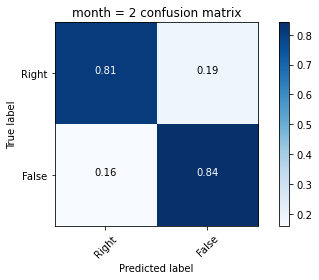

In [7]:
from sklearn.metrics import classification_report

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow import keras

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def convert_to_labels(one_hot_encoding):
    Labels = []
    for i in range(5527):
        if one_hot_encoding[i][0] > 0.5:
            Labels.append(1)
        else:
            Labels.append(0)
    
    return Labels


m = keras.models.load_model(r'C:\Users\usaco\Desktop\Main_Program\model_check3_2D.h5')
y_predict = m.predict(X_test, batch_size=None, verbose=1, steps=None)

y_pred = convert_to_labels(y_predict)
#print(y_pred)
y_true = convert_to_labels(y_test)
#print(y_true)
target_names = ['Right', 'False']
month = 2

print ("month = " + str(month))
print(classification_report(y_true, y_pred, target_names=target_names))
print ("**************************************************************")

plt.figure()
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,
                    title="month = " + str(month) + ' confusion matrix')

plt.show()

In [ ]:
'Convert to TFLite'

In [8]:
import tensorflow.compat.v2 as tf
from tensorflow import keras
import tensorflow as tf
import numpy as np
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)
    
print(tf.__version__)
assert tf.__version__ >= '2.3'


2.5.0


In [9]:
model=keras.models.load_model(r'C:\Users\usaco\Desktop\Main_Program\model_check3_2D.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\usaco\AppData\Local\Temp\tmpb660rggs\assets


INFO:tensorflow:Assets written to: C:\Users\usaco\AppData\Local\Temp\tmpb660rggs\assets


In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\usaco\AppData\Local\Temp\tmpp_httkgk\assets


INFO:tensorflow:Assets written to: C:\Users\usaco\AppData\Local\Temp\tmpp_httkgk\assets


In [11]:
print(X_train.dtype)
X_train = X_train.astype(np.float32)
print(X_train.dtype)

print(X_test.dtype)
X_test = X_test.astype(np.float32)
print(X_test.dtype)


float64
float32
float64
float32


In [18]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]

# Set the input and output tensors to INT16 (APIs added in r2.3)
converter.inference_input_type = tf.int16
converter.inference_output_type = tf.int16
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\usaco\AppData\Local\Temp\tmpgfaezkub\assets


INFO:tensorflow:Assets written to: C:\Users\usaco\AppData\Local\Temp\tmpgfaezkub\assets


In [92]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [93]:
import pathlib

tflite_models_dir = pathlib.Path(r"C:\Users\usaco\Desktop\Main_Program")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"model3_2D.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"model3_2D_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

271888

In [94]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = X_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [95]:
tflite_file = r'C:\Users\usaco\Desktop\Main_Program\model1_2D_quant.tflite'
test_image_indices = X_test

run_tflite_model(tflite_file, test_image_indices)

IndexError: arrays used as indices must be of integer (or boolean) type